<a href="https://colab.research.google.com/github/CeliaDiazSanchez/Data-Mining/blob/LAB05/LAB05_RINGS_Ana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

Se desea desarrollar un modelo predictivo para estimar la edad de un molusco utilizando tres bases de datos que contienen información sobre el sexo, longitud, diámetro, altura, peso total, peso desprendido, peso de las vísceras y peso de la concha del molusco. El objetivo es construir un modelo preciso que pueda predecir la edad del molusco basándose en estas características físicas.

# Instalación paquetes

Instalamos la biblioteca "eli5" que nos ayuda a comprender como funcionan y toman las decisiones los modelos.

In [1]:
!pip install eli5

# Instalación librerías y funciones

In [2]:
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import requests
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Función para crear variables y dividirlas
def crear_modelo(df, c_obj):
    x = df.drop([c_obj], axis=1)
    y = df[c_obj]
    # Realizar la división en K folds
    r_kf = division_Kfolds(5, x, y)  # Cambiar el número de divisiones según sea necesario
    return r_kf

# Creando un clasificador de árbol de decisión
def entrenar_modelo(x_train, x_test, y_train, y_test, c_obj):
    modelo = DecisionTreeClassifier()
    # Entrenar el modelo
    modelo.fit(x_train, y_train)
    # Probar el modelo
    predicciones = modelo.predict(x_test)
    # Obtener las métricas
    exactitud = metrics.accuracy_score(y_test, predicciones)
    redondeada = round(exactitud * 100, 2)
    return redondeada


#Perform K folds splitting
def division_Kfolds(folds,x,y):
  KF = KFold(n_splits=folds)
  k = 1
  ltrain = []
  laccuracy = []

  for train, test in KF.split(x):
    x_train, x_test = x.iloc[train], x.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    accuracy = entrenar_modelo(x_train, x_test, y_train, y_test,f'División número: {k}')
    ltrain.append(train)
    laccuracy.append(accuracy)
    k+=1
  print(f"La máxima precisión en {folds} divisiones es {max(laccuracy)}")
  return ltrain, laccuracy, x_test, y_test

def discretizar(df,columna,n):
    discretizador = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy="uniform")
    discretizado = discretizador.fit_transform(df[columna].values.reshape(-1, 1))
    discretizado = discretizado.reshape(-1)
    return discretizado


Leemos los archivos correspondientes.

In [3]:
# URL del archivo CSV en GitHub
url = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB05/abalone.csv"
nombre = 'abalone.csv'

url2 = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB05/abalone_original.csv"
nombre2 = 'abalone_original.csv'

url3 = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB05/mix_abalone_train.csv"
nombre3 = 'mix_abalone_train.csv'

# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")

# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url2)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre2, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")

# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url3)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre3, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")


Archivo descargado exitosamente.
Archivo descargado exitosamente.
Archivo descargado exitosamente.


Para mayor fiabilidad de los modelos que vamos a crear, utilizamos 3 bases de datos de fuentes distintas, todas ellas recogen información sobre los abalones.

Cargamos los 3 archivos que usaremos a lo largo de la práctica como nuestra base de datos.

En este caso utilizaremos abalone, abalone_original y mix_abalone_train.

#### **Primera base de datos**

Recogida de https://archive.ics.uci.edu/dataset/1/abalone
Contiene las siguientes variables, explicadas en el link anterior como:

* **Sex**: M, F, and I (infant).
* **Length**: Longest shell measurement, measured in mm.
* **Diameter**: perpendicular to length, measured in mm.
* **Height**: with meat in shell, measured in mm.
* **Whole weight**:	whole abalone	measured in grams.
* **Shucked weight**: weight of meat measured in	grams.
* **Viscera weight**: gut weight (after bleeding), measured in grams.
* **Shell weight**: after being dried,	measured in grams.
* **Rings**: +1.5 gives the age in years

In [4]:
# df2 = pd.read_csv('abalone_original.csv')
# Mostramos las 5 primeras entradas del dataset
# df2.head(5)

#### **Segunda base de datos**

Recogida de https://archive.ics.uci.edu/dataset/1/abalone

> "From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200)."



(Es la misma que la primera pero con los datos escalados)


In [5]:
df = pd.read_csv('abalone.csv')
# df_sorted = df.sort_values(by='Whole weight', ascending=True)
# Mostramos las 5 primeras entradas del dataset
df.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [6]:
df.shape

(4177, 9)

Tiene `4177 filas` y `9 columnas`

In [7]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


#### **Tercera base de datos**

Recogida de ...
Contiene las siguientes variables, explicadas en el link anterior:

* **Sex**: M, F, and I (infant).
* **Length**: Longest shell measurement, measured in mm.
* **Diameter**: perpendicular to length, measured in mm.
* **Height**: with meat in shell, measured in mm.
* **Whole weight**:	whole abalone	measured in grams.
* **Shucked weight**: weight of meat measured in	grams.
* **Viscera weight**: gut weight (after bleeding), measured in grams.
* **Shell weight**: after being dried,	measured in grams.
* **Rings**: +1.5 gives the age in years

Tiene los datos escalados dividos entre 200 del original.

In [8]:
df2 = pd.read_csv(nombre3)
# df_sorted3 = df3.sort_values(by='Height', ascending=False)
# Mostramos las 5 primeras entradas del dataset
df2.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [9]:
df2.shape

(94792, 9)

Tiene `94792 filas` o registros y `9 columnas` o atributos

In [10]:
df2.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000
mean,0.517402,0.401952,0.135643,0.790785,0.341597,0.169914,0.226468,9.707233
std,0.118308,0.098088,0.038193,0.459231,0.205267,0.101334,0.130639,3.178704
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419500,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.072500,0.464500,0.233000,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Más adelante analizaremos los posibles outliers.

#### __Manipulación de las distintas bases de datos__

Los valores de ambas bases de datos tienen medidas estadísticas similares. Comprobamos que haya variedad de observaciones entre ambas bases de datos. Como `df` tiene menos registros que `df2`:

In [11]:
# Contar cuántas filas de df están contenidas en df2
num_rows_in_df2 = df.isin(df2).all(axis=1).sum()

# Mostrar el resultado
print("Número de filas de df contenidas en df2:", num_rows_in_df2)

Número de filas de df contenidas en df2: 0


Esto es muy conveniente, ya que no queremos usar bases de datos que hayan utilizado las mismas observaciones, es decir, queremos que cada base de datos contenga medidas de abalones distintos.

Cambiamos los nombres de las columnas del segundo archivo, para eliminar errores de transcripción, como que haya una barras bajas "_" en vez de espacios.

In [12]:
# Columnas del primer dataframe
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [13]:
# Columnas del segundo dataframe
df2.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

In [14]:
# Renombrar las columnas del segundo dataframe para que coincidan con las del primero
columnas = df.columns
df2.columns = columnas

Combinamos las bases de datos `df` y `df2` en una sola llamada `df_c` y guardamos esta base de datos en un nuevo archivo CSV llamado `df_c.csv`.

In [33]:
# Combina las bases de datos
df_c = pd.concat([df, df2], ignore_index=True)

# Guarda la base de datos combinada en un nuevo archivo CSV
df_c.to_csv('df_c.csv', index=False)
df_c.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Como podemos observar en nuestra nueva base de datos, tenemos todos los datos en un solo archivo CSV.

# Exploración y limpieza de la base de datos

####**Estudio de NaNs**

Comprobamos si hay algún NaN en nuestra base de datos.

In [16]:
df_c.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

No hay valores nulos en ninguna de las columnas de la base de datos combinada, ya que vemos que cada columna tiene 0 valores nulos, lo que significa que no falta ningún dato en ninguna de las variables.

#### **Dimensiones de la base de datos**

La base de datos combinada consta de un total de `98,969 registros`, cada uno con `9 atributos` y no encontramos valores nulos en ninguna de las columnas.


In [17]:
df_c.shape

(98969, 9)

No obstante, calculamos y mostramos la cantidad de filas duplicadas, ya que las queremos eliminar para evitar un modelo impreciso debido a observaciones redundantes.

In [18]:
# Filas Repetidas
filas_repetidas = df_c.duplicated().sum()
print("\nCantidad de Filas Repetidas:",filas_repetidas)


Cantidad de Filas Repetidas: 4177


Eliminamos las filas duplicadas de la base de datos combinada y luego mostramos la nueva forma del DataFrame para confirmar que las filas duplicadas han sido eliminadas.

In [34]:
# Eliminamos filas duplicadas
df_c = df_c.drop_duplicates()

# Verificamos la nueva forma del DataFrame después de eliminar las filas duplicadas
print("Forma del DataFrame después de eliminar filas duplicadas:", df_c.shape)


Forma del DataFrame después de eliminar filas duplicadas: (94792, 9)


Tras la eliminación de los duplicados, el DataFrame resultante tiene:
$ 98.969 - 4.177 = 94.792 $ filas.

#### **Análisis de las variables**

En este apartado obtenemos los tipos de datos de cada columna en la base de datos combinada y los imprimimos.

In [20]:
tipos_datos = df_c.dtypes
print("\nTipos de Datos:\n",tipos_datos)


Tipos de Datos:
 Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


* `float64` se usa para variables continuas como el diámetro y el peso.
* `int64` se usa para la variable que cuenta el número de anillos, ya que solo puede tomar valores enteros.
* `object` se usa para la variable que categoriza el sexo del abalón.



Cuando pandas no puede inferir el tipo de datos correctamente, por defecto define la columna como tipo object, que es una categoría general que puede contener diversos tipos de datos, incluyendo cadenas de texto como es el caso.

En la descripción de la base de datos, vimos que `Sex` tomaba los valores 'M', 'F', 'I' para denotar male, female, infant respectivamente. Por lo que transformamos esta variable a tipo categórico.

In [35]:
df_c['Sex'] = df_c['Sex'].astype('category')
# Verificar la transformación
print(df_c.dtypes[0])

category


A continuación veamos su distribución mediante la creación de un diagrama de barras usando `seaborn`.

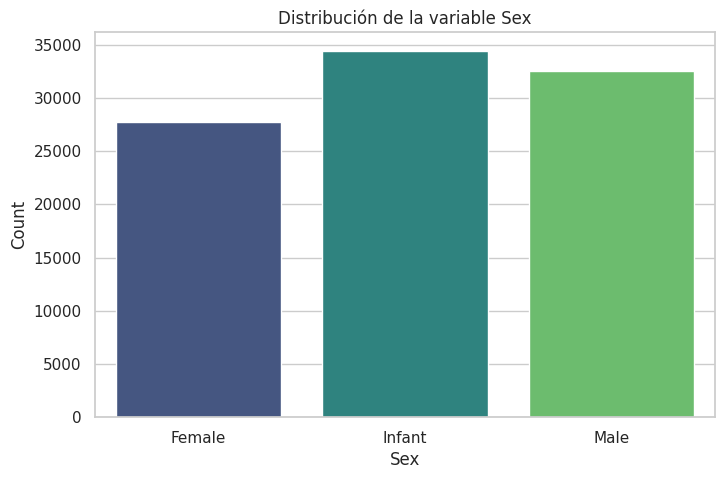

In [46]:
# Crear la figura
plt.figure(figsize=(8, 5))

# Mapear los valores de la columna 'Sex' a etiquetas descriptivas solo para graficar
sex_labels = {'M': 'Male', 'F': 'Female', 'I': 'Infant'}
sns.countplot(x=df_c['Sex'].map(sex_labels), palette='viridis')

# Configuraciones del gráfico de barras
plt.title('Distribución de la variable Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

Observamos que la mayoría de abalones son `infant` aunque no por mucha diferencia (aprox 5 mil infantes más).

**Variable objetivo**

Los anillos en los abulones son estructuras que se forman en sus caparazones a medida que crecen, de manera similar a los anillos de crecimiento en los árboles.

Según Chatgpt: en general, el número de anillos de un Haliotis corrugata adulto suele estar en el rango de 5 a 20 anillos.

In [42]:
print("El abulón con más anillos del dataFrame tiene",df_c['Rings'].max(),"anillos, es decir," ,df_c['Rings'].max()+1.5,"años")

El abulón con más anillos del dataFrame tiene 29 anillos, es decir, 30.5 años


En el siguiento texto, se identifica que la edad máxima encontrada de manera natural fue de `20 años`. Por factores externos como la sobrepesca del reclutamiento, pueden desarrollarse abulones de hasta `25 años`.
> Nosotros encontramos en 1997 una edad máxima de 16 años para H. corrugata, mientras que Muñoz López (1976) reportó individuos de hasta 21 años antes de 1976, y Shepherd y Ávalos-Borja (1997) individuos de 18 años en 1970 para Isla Natividad, BCS, México, ambos usando la técnica de los anillos de la espira. Marín (1981), usando distribuciones de frecuencia de tallas, reporta un grupo de edad de 20 años.

> Una situación similar ocurre con H. fulgens. En este trabajo se encontró una edad máxima de 20 años, que es una cantidad menor de grupos de edad respecto a 1982 y 1985 cuando Turrubiates-Morales y Castro-Ortiz (1992) reportan, para la misma zona y usando la técnica del presente trabajo, individuos de hasta 25 años. Esta situación podría ser una evidencia de sobrepesca del reclutamiento, que sería la disminución de adultos de una manera tal que no se producen suficientes huevecillos para remplazar el reclutamiento. La pesca retira los organismos más viejos, que es una de las principales características de las poblaciones explotadas a niveles de intensidad importantes.

https://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S0185-38802003000100009

Queremos un modelo que pueda determinar la edad del abulón, incluso en zonas de sobrepesca, por lo que no eliminaremos valores extremos. Es más, se le podría dar un nuevo enfoque al modelo, ya que si se encuentra un abulón extremadamente viejo, podría ser indicativo de que se encuentre en una zona explotada por la pesca de sus depredadores.

Sabemos que si se suma 1.5 al número de anillos, se obtiene la edad del molusco. Tomando como edad máxima 25 años, el número máximo de anillos lógico sería 23.5, redondeado a 24. Por ello eliminamos los valores mayores a 24 para la variable `Rings`

In [44]:
# Recuento del número de registros con un número de anillos fuera del rango
greater_than_24 = (df_c['Rings'] > 15).sum()
print(greater_than_24 )

5546


Recordamos que el dataFrame tenía 94.792 filas, es decir, aproximadamente un 6% de las observaciones tienen un número de anillos extremo.Eliminamos esos registros.

In [45]:
# Eliminar las observaciones con 'rings' mayor que 24
df_c = df_c[df_c['Rings'] <= 24]

In [47]:
df_c.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,94682.000000,94682.000000,94682.000000,94682.000000,94682.000000,94682.000000,94682.000000,94682.000000
mean,0.517301,0.401860,0.135594,0.790275,0.341463,0.169826,0.226243,9.687301
std,0.118324,0.098092,0.038180,0.459111,0.205291,0.101335,0.130457,3.125912
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419500,0.177500,0.086500,0.120000,8.000000
50%,0.540000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.072000,0.464000,0.232500,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,24.000000


Para analizar el resto de variables numéricas, y sus posibles outliers, hacemos uso de boxplots:

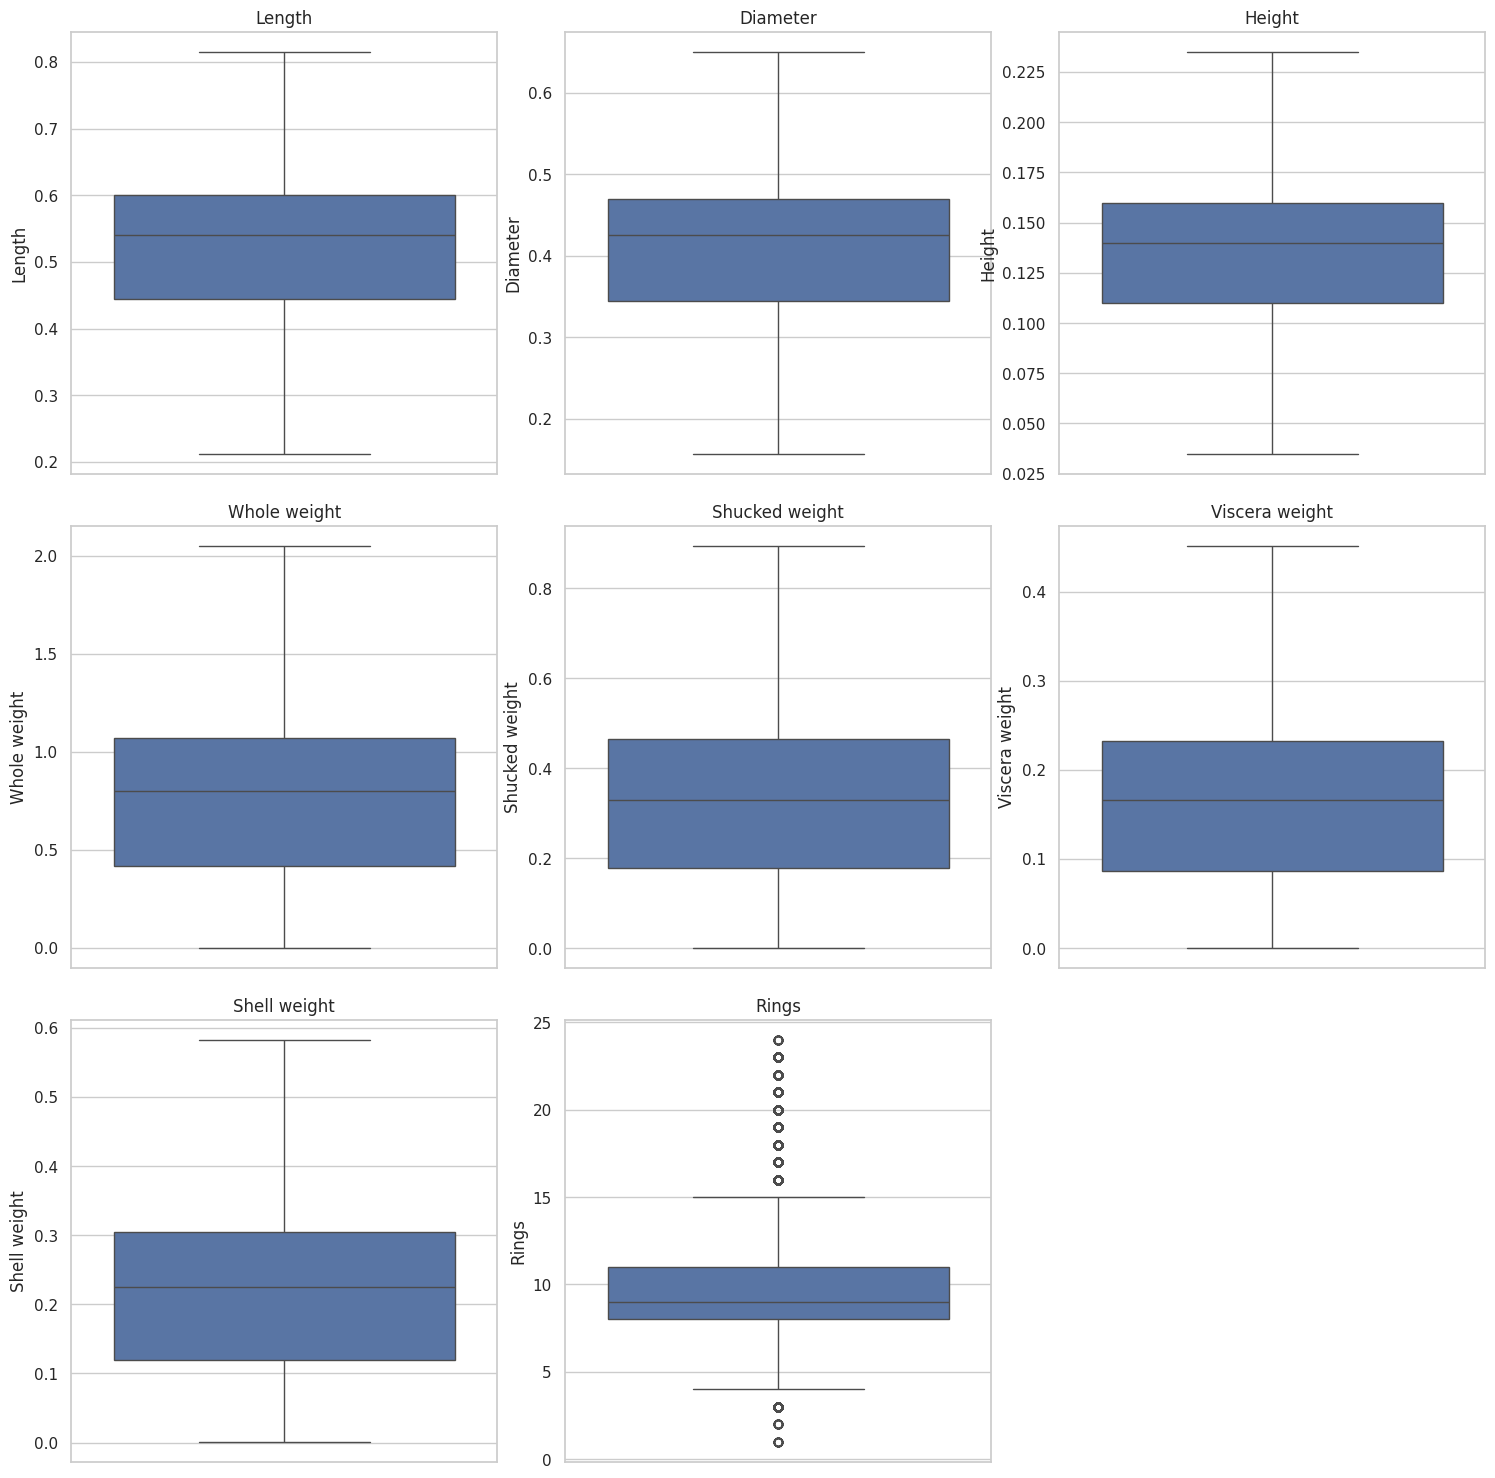

In [51]:
# Configuración opcional para mejorar el aspecto de los gráficos
sns.set(style="whitegrid")

# Seleccionar solo las columnas numéricas
columnas = df_c.select_dtypes(include=['int', 'float']).columns

# Obtener el número de columnas en el dataframe
num_cols = len(columnas)

# número de filas y columnas para los subplots
num_rows = 3
num_cols_subplot = 3

# Crear subplots
fig, axes = plt.subplots(num_rows, num_cols_subplot, figsize=(15, 5 * num_rows))

# Ajustar el diseño para evitar la superposición de etiquetas
plt.tight_layout()

# Crear boxplots para cada columna en el dataframe
for i, col in enumerate(columnas):
      row_idx = i // num_cols_subplot
      col_idx = i % num_cols_subplot
      ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
      sns.boxplot(data=df_c[col], ax=ax)
      ax.set_title(col)

# Eliminar subplots no utilizados
for i in range(num_cols, num_rows * num_cols_subplot):
    row_idx = i // num_cols_subplot
    col_idx = i % num_cols_subplot
    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
    fig.delaxes(ax)

# Mostrar los subplots
plt.show()


Hay outliers en todas las variables. Y hay demasiados de ellos como para eliminarlos, estaríamos perdiendo mucha información, es por ello que vamos a sustituir los outliers por los valores `upper bound` o `lower bound` de los boxplots. Es decir, por el valor de los cuartiles superior o inferior.

In [50]:
# Seleccionar solo las columnas de tipo float
numeric_cols = df_c.select_dtypes(include=['float'])

# Iterar sobre cada columna numérica
for col in numeric_cols:
    # Calcular el rango intercuartil (IQR) de manera automática
    Q1 = df_c[col].quantile(0.25)
    Q3 = df_c[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites para identificar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Reemplazar outliers por los valores del cuartil superior o inferior
    df_c[col] = df_c[col].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)


Una vez que las variables han sido limpiadas de outliers, creamos histogramas para identificar patrones de distribución.

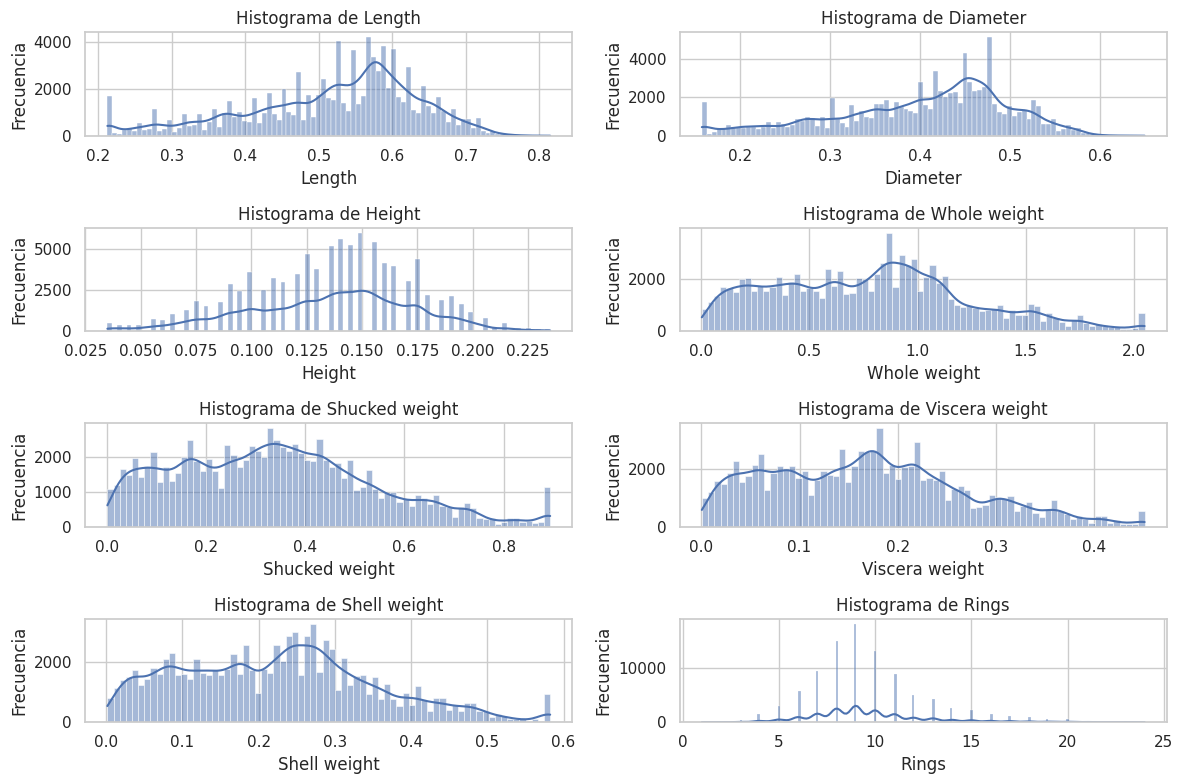

In [54]:
# Lista de columnas para hacer histogramas
col_hist = df_c.select_dtypes(include=['int', 'float'])

# Configuración de tamaño de la figura
num_cols = len(col_hist.columns)
num_rows = (num_cols + 1) // 2  # Calcular el número de filas necesario
plt.figure(figsize=(12, 8))

# Iteración sobre las columnas para generar histogramas
for i, columna in enumerate(col_hist, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(df_c[columna], kde=True)  # Utilizamos histplot en lugar de boxplot
    plt.title(f'Histograma de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Variables que miden el peso, tienen, como es de esperar, distribuciones muy similares. Por otra parte observamos que la altura se mide de manera discreta.

In [56]:
df_c['Height'].unique()

array([0.095 , 0.09  , 0.135 , 0.125 , 0.08  , 0.15  , 0.14  , 0.11  ,
       0.145 , 0.1   , 0.13  , 0.085 , 0.155 , 0.165 , 0.185 , 0.18  ,
       0.175 , 0.2   , 0.105 , 0.045 , 0.055 , 0.05  , 0.12  , 0.07  ,
       0.16  , 0.06  , 0.17  , 0.195 , 0.19  , 0.115 , 0.075 , 0.065 ,
       0.215 , 0.21  , 0.23  , 0.205 , 0.22  , 0.04  , 0.035 , 0.035 ,
       0.225 , 0.235 , 0.235 , 0.106 , 0.0615, 0.0735, 0.116 , 0.103 ,
       0.169 , 0.117 , 0.083 , 0.119 , 0.036 , 0.0915, 0.156 , 0.092 ,
       0.057 , 0.0825, 0.123 , 0.088 , 0.082 , 0.046 , 0.167 , 0.113 ,
       0.184 , 0.121 , 0.044 , 0.147 , 0.0925])

Debido al proceso llevado a cabo para eliminar outliers, los valores del cuartil superior e inferior de cada variable tendrán una mayor frecuencia.

A continuación, calculamos de manera analítica las correlaciones entre variables.

In [78]:
# Lista de columnas para calcular la matriz de correlación
col_hist3 = df_c.select_dtypes(include=['int', 'float'])

# Crear una copia del DataFrame con solo las columnas de interés
df_regr = df_c.copy()

# Convertir la variable categórica 'Sex' a una representación numérica
df_regr['Sex'] = df_regr['Sex'].astype('category').cat.codes

# Calcular la matriz de correlación
matriz_correlacion = df_regr.corr()

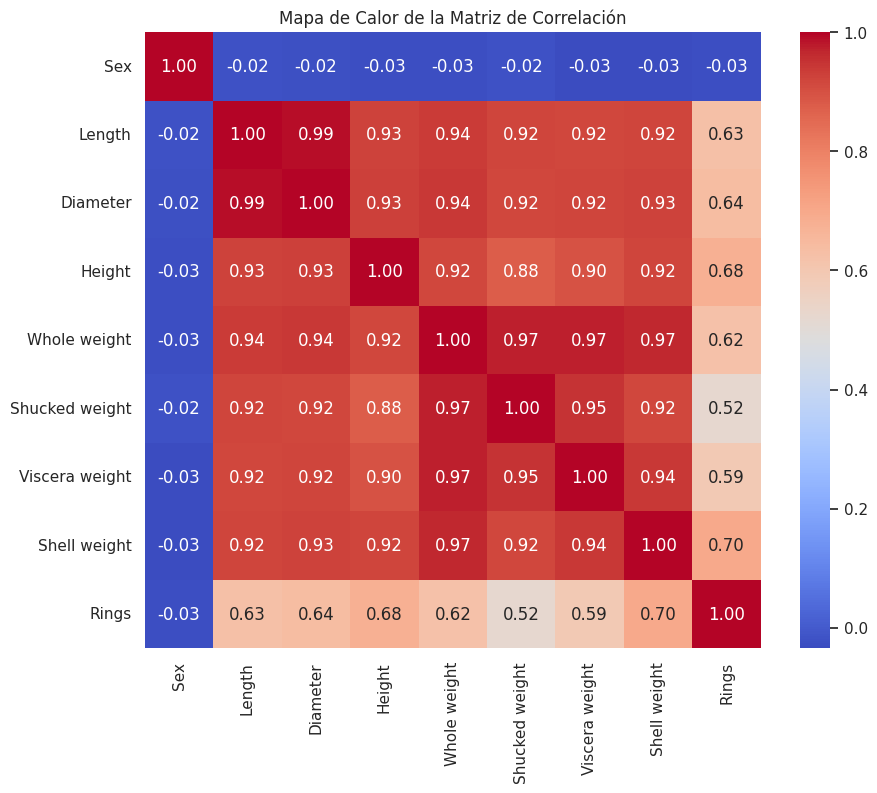

In [79]:
# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

Hay altos niveles de correlación directa para todas las variables numéricas. Se explica de manera intuitiva, puesto que a mayor tamaño del abulón, mayor será su diámetro de concha, altura y pesos. Son variables que dependen unas de otras.

El sexo, sin embargo, no depende del resto de variables, es decir el tamaño y peso de los abulones no varía dependiendo del sexo.

---



Eliminamos las variables `Shucked weight`, `Viscera weight` y `Shell weight` puesto que son variables más costosas de medir que `Whole weight`. Así ahorramos al usuario tener que separar la concha de las visceras y de la carne, una tarea poco apetecible. Además, eliminando estas variables, se da la opción de devolver al mar al abulón, sin tener que matarlo en el proceso de tomar sus datos.

Por otra parte, aparece un nuevo enfoque, predecir la variable `Shucked weight`, para que restaurantes puedan conocer el peso exacto de la carne de los abulones que compran al por mayor.

\_Nota_\: El "shucked weight" es el peso de la carne comestible del abulón después de ser removido de su caparazón, mientras que el "viscera weight" es el peso de los órganos internos del abulón que no se consumen típicamente como alimento.

In [80]:
df_regr = df_regr.drop(columns=['Shucked weight', 'Viscera weight', 'Shell weight'])



---



Eliminamos las variables `Diameter` y `Length` ya que también son más complicada de medir que la altura.

Según ChatGPT:
> El diámetro del abulón se mide como la distancia máxima entre dos puntos opuestos en su caparazón. Esta medida se toma con una regla o un calibrador, colocando el instrumento de medición en una posición perpendicular al caparazón del abulón y tomando la medida desde el borde exterior de un lado hasta el borde exterior del lado opuesto. Es importante asegurarse de tomar la medida en el punto más ancho del abulón para obtener una medida precisa del diámetro.

> La medida de "length" (longitud) del abulón se refiere a la distancia desde el extremo más largo del caparazón hasta el extremo opuesto. Se mide de manera similar al diámetro, tomando la medida desde el punto más alejado en un extremo del abulón hasta el punto más alejado en el extremo opuesto, siguiendo la curva del caparazón.

> La medida de "height" (altura) del abulón se refiere a la distancia vertical desde la base del caparazón hasta el punto más alto del mismo. Se puede medir colocando el abulón sobre una superficie plana y tomando la medida verticalmente desde la base hasta el punto más alto del caparazón.

In [82]:
df_regr = df_regr.drop(columns=['Diameter','Length'])

KeyError: "['Diameter', 'Length'] not found in axis"



---



Recordamos que este proyecto busca, no solo predecir características de los abulones, sino también facilitar el trabajo de biólogos, mayoristas y criadores de este animal. Por lo que evitamos utilizar variables cuya medición les requiera de más trabajo.

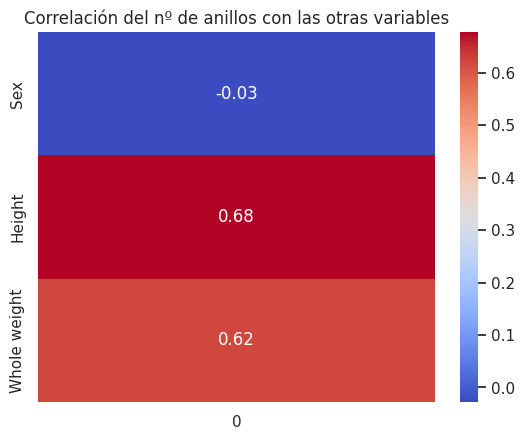

In [84]:
# Calcula la matriz de correlación
rings_corr = df_regr.drop(columns=['Rings']).corrwith(df_regr['Rings'])

# Generar el mapa de calor utilizando Seaborn
sns.heatmap(rings_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Correlación del nº de anillos con las otras variables')

# Mostrar el gráfico
plt.show()

Las variables restantes `Whole weight` y `Height` tienen una correlación directa alta con la variable objetivo, mientras que `Sex` tiene una menor correlación inversa.

Para analizar `sex` de manera adecuada, puesto que es una variable categórica, haremos un gráfico de dispersión en base a los anillos de cada categoría.



---



In [ ]:
for col in ['Diameter', 'Height', 'Whole_weight', 'Rings']:
    if col != "Rings":
        # Discretize with 15 bins for continuous data
        df_regr[col] = pd.DataFrame(discretizar(df_regr, col, 15), columns=[col])
    else:
        # Discretize with 5 bins for the 'Rings' column
        df_regr[col] = pd.DataFrame(discretizar(df_regr, col, 5), columns=[col])

# Eliminar filas que contienen valores NaN
df_regr.dropna(inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
x = df_regr.drop(columns=['Rings'])  # Variables independientes
y = df_regr["Rings"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
num_datos = df_regr.shape[0]  # Obtiene el número de filas
print("El número de datos en el DataFrame df_regr es:", num_datos)

El número de datos en el DataFrame df_regr es: 87014


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import matplotlib.pyplot as plt

folds = [100, 500, 1000, 1500, 2000, 2500, 3000]
accuracies = []

for i in folds:
    _, accuracy, _, _ = division_Kfolds(i, x, y)
    accuracies.append(max(accuracy))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La máxima precisión es 100 divisiones es 71.15
La máxima precisión es 500 divisiones es 78.86
La máxima precisión es 1000 divisiones es 87.36
La máxima precisión es 1500 divisiones es 93.1
La máxima precisión es 2000 divisiones es 90.91
La máxima precisión es 2500 divisiones es 100.0
La máxima precisión es 3000 divisiones es 96.55


In [ ]:
accuracies = [71.15, 78.86, 87.36, 93.1, 90.91, 100.0, 96.55]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


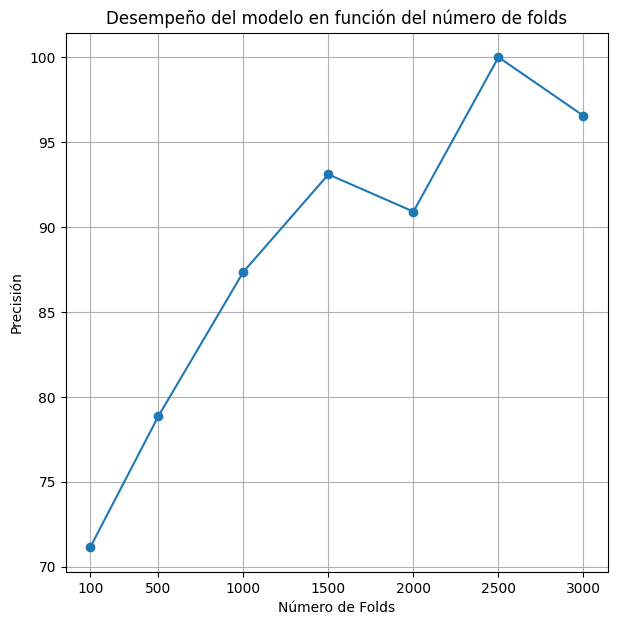

In [ ]:
# Graficar el desempeño en función del número de folds
plt.figure(figsize=(7, 7))
plt.plot(folds, accuracies, marker='o', linestyle='-')
plt.title('Desempeño del modelo en función del número de folds')
plt.xlabel('Número de Folds')
plt.ylabel('Precisión')
plt.grid(True)
plt.xticks(folds)
plt.show()

explicar

In [ ]:
ltrain, laccuracy, x_test, y_test = division_Kfolds(1500, x, y)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La máxima precisión es 1500 divisiones es 93.1


In [ ]:
# Escogemos la mejor división (1500)
max_index = laccuracy.index(max(laccuracy))
model = DecisionTreeClassifier()
model.fit(x.iloc[ltrain[max_index]], y.iloc[ltrain[max_index]])
print("Visualización de atributos relacionadas con los Rings predichos")
permutacion = PermutationImportance(model, random_state = 0).fit(x_test, y_test)

Visualización de atributos relacionadas con los Rings predichos


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Generar la tabla con el color de fondo personalizado
html_table = eli5.show_weights(permutacion, feature_names=x_test.columns.tolist()).data

# Cambiar el color de fondo de la tabla
html_table = html_table.replace('<table ', '<table style="background-color: #FFA500;" ')

# Mostrar la tabla HTML
from IPython.display import HTML
HTML(html_table)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Weight,Feature
0.1759 ± 0.0507,Whole_weight
0.1207 ± 0.1647,Diameter
0.0759 ± 0.0414,Height
